## SEAL - An Implementation of SEAL for citation network (Cora) Link Prediction Tasks


Implementation of SEAL for link prediction (learning from Subgraphs, Embeddings and Attributes for Link prediction) from M. Zhang, P. Li, Y. Xia, K. Wang, and L. Jin, Labeling Trick: A Theory of Using Graph Neural Networks for Multi-Node Representation Learning. [\[PDF\]](https://arxiv.org/pdf/2010.16103.pdf)

SEAL is a GNN-based link prediction method. It first extracts a k-hop enclosing subgraph for each target link, then applies a labeling trick named Double Radius Node Labeling (DRNL) to give each node an integer label as its additional feature. Finally, these labeled enclosing subgraphs are fed to a graph neural network to predict link existences. This implementation uses Graph Convolutional Network (GCN) operations.

This notebook adapts SEAL from https://github.com/facebookresearch/SEAL_OGB with the PyTorch-Geometric library and PyTorch Lightning. It tests SEAL on the citation network dataset, Cora, from the paper [Revisiting Semi-Supervised Learning with Graph Embeddings
](https://arxiv.org/abs/1603.08861). Evaluation metrics are AP and AUROC.

In [1]:
!pip3 install ogb pytorch_lightning -q

try:
    import torch_geometric
except:
    import torch
    
    CUDA = 'cu102' if torch.cuda.is_available() else 'cpu'
    TORCH = "1.11.0"
    
    ! pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html -q
    ! pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html -q
    ! pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html -q
    ! pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html -q
    ! pip install git+https://github.com/pyg-team/pytorch_geometric.git -q

In [2]:
import math
import os.path as osp
import argparse
from itertools import chain

import numpy as np

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchmetrics import AveragePrecision, AUROC
from pytorch_lightning import (LightningDataModule, LightningModule, Trainer,
                               seed_everything)
from pytorch_lightning.callbacks import ModelCheckpoint

from torch_geometric.loader import NeighborSampler
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import to_undirected, negative_sampling, add_self_loops
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid, CoraFull

from ogb.linkproppred import PygLinkPropPredDataset, Evaluator

from torch.nn import BCEWithLogitsLoss, Conv1d, MaxPool1d, ModuleList

from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, GCNConv, global_sort_pool
import torch_geometric.transforms as T
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import k_hop_subgraph, to_scipy_sparse_matrix
from scipy.sparse.csgraph import shortest_path


In [3]:
seed_everything(1)

1

In [4]:

class SEALDataset(InMemoryDataset):
    def __init__(self, dataset, num_hops, use_features=False, split='train'):
        self.data = dataset[0]
        self.num_hops = num_hops
        self.use_features = use_features
        super().__init__(dataset.root)
        index = ['train', 'val', 'test'].index(split)
        self.data, self.slices = torch.load(self.processed_paths[index])

    @property
    def processed_file_names(self):
        return ['SEAL_train_data.pt', 'SEAL_val_data.pt', 'SEAL_test_data.pt']

    def process(self):
        transform = RandomLinkSplit(num_val=0.05, num_test=0.1,
                                    is_undirected=True, split_labels=True)
        train_data, val_data, test_data = transform(self.data)

        self._max_z = 0

        # Collect a list of subgraphs for training, validation and testing:
        train_pos_data_list = self.extract_enclosing_subgraphs(
            train_data.edge_index, train_data.pos_edge_label_index, y=1)
        train_neg_data_list = self.extract_enclosing_subgraphs(
            train_data.edge_index, train_data.neg_edge_label_index, y=0)

        val_pos_data_list = self.extract_enclosing_subgraphs(
            val_data.edge_index, val_data.pos_edge_label_index, y=1)
        val_neg_data_list = self.extract_enclosing_subgraphs(
            val_data.edge_index, val_data.neg_edge_label_index, y=0)

        test_pos_data_list = self.extract_enclosing_subgraphs(
            test_data.edge_index, test_data.pos_edge_label_index, y=1)
        test_neg_data_list = self.extract_enclosing_subgraphs(
            test_data.edge_index, test_data.neg_edge_label_index, y=0)

        # Convert node labeling to one-hot features.
        for data in chain(train_pos_data_list, train_neg_data_list,
                          val_pos_data_list, val_neg_data_list,
                          test_pos_data_list, test_neg_data_list):
            # We solely learn links from structure, dropping any node features: 
            z = F.one_hot(data.z, self._max_z + 1).to(torch.float)
            if self.use_features:
                z = torch.cat([z, data.x], 1)
            data.x = z

        torch.save(self.collate(train_pos_data_list + train_neg_data_list),
                   self.processed_paths[0])
        torch.save(self.collate(val_pos_data_list + val_neg_data_list),
                   self.processed_paths[1])
        torch.save(self.collate(test_pos_data_list + test_neg_data_list),
                   self.processed_paths[2])

    def extract_enclosing_subgraphs(self, edge_index, edge_label_index, y):
        """
        Extract enclosing subgraphs for every pair of nodes in the graph and label the nodes
        in each subgraph.

        Args:
        :param edge_index : edges in the graph
        :param edge_label_index : true edges in the graph
        :param y : if true link 
        """
        data_list = []
        for src, dst in edge_label_index.t().tolist():
            sub_nodes, sub_edge_index, mapping, _ = k_hop_subgraph(
                [src, dst], self.num_hops, edge_index, relabel_nodes=True)
            src, dst = mapping.tolist()

            # Remove target link from the subgraph.
            mask1 = (sub_edge_index[0] != src) | (sub_edge_index[1] != dst)
            mask2 = (sub_edge_index[0] != dst) | (sub_edge_index[1] != src)
            sub_edge_index = sub_edge_index[:, mask1 & mask2]

            # Calculate node labeling.
            z = self.drnl_node_labeling(sub_edge_index, src, dst,
                                        num_nodes=sub_nodes.size(0))

            data = Data(x=self.data.x[sub_nodes], z=z,
                        edge_index=sub_edge_index, y=y)
            data_list.append(data)

        return data_list

    def drnl_node_labeling(self, edge_index, src, dst, num_nodes=None):
        # Double-radius node labeling (DRNL).
        src, dst = (dst, src) if src > dst else (src, dst)
        adj = to_scipy_sparse_matrix(edge_index, num_nodes=num_nodes).tocsr()

        idx = list(range(src)) + list(range(src + 1, adj.shape[0]))
        adj_wo_src = adj[idx, :][:, idx]

        idx = list(range(dst)) + list(range(dst + 1, adj.shape[0]))
        adj_wo_dst = adj[idx, :][:, idx]

        dist2src = shortest_path(adj_wo_dst, directed=False, unweighted=True,
                                 indices=src)
        dist2src = np.insert(dist2src, dst, 0, axis=0)
        dist2src = torch.from_numpy(dist2src)

        dist2dst = shortest_path(adj_wo_src, directed=False, unweighted=True,
                                 indices=dst - 1)
        dist2dst = np.insert(dist2dst, src, 0, axis=0)
        dist2dst = torch.from_numpy(dist2dst)

        dist = dist2src + dist2dst
        dist_over_2, dist_mod_2 = dist // 2, dist % 2

        z = 1 + torch.min(dist2src, dist2dst)
        z += dist_over_2 * (dist_over_2 + dist_mod_2 - 1)
        z[src] = 1.
        z[dst] = 1.
        z[torch.isnan(z)] = 0.

        self._max_z = max(int(z.max()), self._max_z)

        return z.to(torch.long)

In [5]:
class LightningSEALDataset(LightningDataModule):
    def __init__(self,
                 train_dataset: Data,
                 val_dataset: Data,
                 test_dataset: Data,
                 batch_size: int = 1,
                 num_workers: int = 0,
                 **kwargs):
        super().__init__()
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        self.batch_size = batch_size
        self.num_workers = num_workers
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset, 
                          batch_size=self.batch_size, 
                          shuffle=True,
                          num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, 
                          batch_size=self.batch_size, 
                          shuffle=False,
                          num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, 
                          batch_size=self.batch_size, 
                          shuffle=False,
                          num_workers=self.num_workers)

In [6]:

class DGCNN(torch.nn.Module):
    def __init__(self, hidden_channels, num_layers, train_dataset, GNN=GCNConv, k=0.6):
        super().__init__()

        if k < 1:  # Transform percentile to number.
            num_nodes = sorted([data.num_nodes for data in train_dataset])
            k = num_nodes[int(math.ceil(k * len(num_nodes))) - 1]
            k = max(10, k)
        self.k = int(k)

        self.convs = ModuleList()
        self.convs.append(GNN(train_dataset.num_features, hidden_channels))
        for i in range(0, num_layers - 1):
            self.convs.append(GNN(hidden_channels, hidden_channels))
        self.convs.append(GNN(hidden_channels, 1))

        conv1d_channels = [16, 32]
        total_latent_dim = hidden_channels * num_layers + 1
        conv1d_kws = [total_latent_dim, 5]
        self.conv1 = Conv1d(1, conv1d_channels[0], conv1d_kws[0],
                            conv1d_kws[0])
        self.maxpool1d = MaxPool1d(2, 2)
        self.conv2 = Conv1d(conv1d_channels[0], conv1d_channels[1],
                            conv1d_kws[1], 1)
        dense_dim = int((self.k - 2) / 2 + 1)
        dense_dim = (dense_dim - conv1d_kws[1] + 1) * conv1d_channels[1]
        self.mlp = MLP([dense_dim, 128, 1], dropout=0.5, batch_norm=False)

    def forward(self, x, edge_index, batch):
        xs = [x]
        for conv in self.convs:
                xs += [conv(xs[-1], edge_index).tanh()]
        x = torch.cat(xs[1:], dim=-1)
        
        # Global pooling.
        x = global_sort_pool(x, batch, self.k)
        x = x.unsqueeze(1)  # [num_graphs, 1, k * hidden]
        x = self.conv1(x).relu()
        x = self.maxpool1d(x)
        x = self.conv2(x).relu()
        x = x.view(x.size(0), -1)  # [num_graphs, dense_dim]
        
        return self.mlp(x)

In [7]:
class LightningSEAL(LightningModule):
    def __init__(self, lr, **model_params):
        super().__init__()
        self.lr = lr
        self.model = DGCNN(**model_params)

        self.val_ap = AveragePrecision()
        self.val_auc = AUROC()
        
        self.test_ap = AveragePrecision()
        self.test_auc = AUROC()

        self.criterion = torch.nn.BCEWithLogitsLoss()

    def forward(self, x, edge_index, batch):
        return self.model(x, edge_index, batch)

    def training_step(self, batch, batch_idx: int):
        logits = self(batch.x, batch.edge_index, batch.batch)
        loss = self.criterion(logits.view(-1), batch.y.float())
        
        return loss #* batch.num_graphs

    def validation_step(self, batch, batch_idx: int):
        logits = self(batch.x, batch.edge_index, batch.batch)
        
        y_pred = logits.view(-1) 
        y_true = batch.y.view(-1)
        
        self.val_ap(y_pred, y_true) 
        self.val_auc(y_pred, y_true)
        
        self.log('val_ap', self.val_ap, on_step=False, on_epoch=True,
                 prog_bar=True, sync_dist=True)
        self.log('val_auc', self.val_auc, on_step=False, on_epoch=True,
                 prog_bar=True, sync_dist=True)

    def test_step(self, batch, batch_idx: int):
        logits = self(batch.x, batch.edge_index, batch.batch)
        
        y_pred = logits.view(-1) 
        y_true = batch.y.view(-1)
        
        self.test_ap(y_pred, y_true)
        self.test_auc(y_pred, y_true)
        
        self.log('test_ap', self.test_ap, on_step=False, on_epoch=True,
                 prog_bar=True, sync_dist=True)
        self.log('test_auc', self.test_auc, on_step=False, on_epoch=True,
                 prog_bar=True, sync_dist=True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return [optimizer]
    
    def parameters(self):
        return self.model.parameters()

In [8]:
parser = argparse.ArgumentParser(description='OGBL-Citation2')

parser.add_argument('--model', type=str, default='SEAL',choices=['SEAL'])
parser.add_argument('--num_layers', type=int, default=3)
parser.add_argument('--hidden_channels', type=int, default=32)
parser.add_argument('--use_features', action='store_true', 
                    help="whether to use raw node features as additional GNN input")

parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=100)

parser.add_argument('--devices', type=int, default=1)
parser.add_argument('--num_workers', type=int, default=4)

args = parser.parse_args("")
print(args)

Namespace(batch_size=32, devices=1, epochs=100, hidden_channels=32, lr=0.0001, model='SEAL', num_layers=3, num_workers=4, use_features=False)


In [9]:
path = osp.join(osp.dirname(osp.realpath("__file__")), '..', 'data', 'Planetoid')
dataset = Planetoid(path, name='Cora')

train_dataset = SEALDataset(dataset, num_hops=2, split='train')
val_dataset = SEALDataset(dataset, num_hops=2, split='val')
test_dataset = SEALDataset(dataset, num_hops=2, split='test')

Processing...
Done!
Processing...
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:107: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
Done!


In [10]:
data = dataset[0]
data.y.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

In [11]:
datamodule = LightningSEALDataset(
    train_dataset,
    val_dataset,
    test_dataset,
    batch_size=args.batch_size, 
    num_workers=args.num_workers,
    use_features=args.use_features
)

In [12]:
model = LightningSEAL( 
    lr=args.lr,
    hidden_channels=args.hidden_channels, 
    num_layers=args.num_layers,
    train_dataset=train_dataset
)

print(f'#Params {sum([p.numel() for p in model.parameters()])}')

#Params 96258


/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [13]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_ap', 
    mode='max',
    save_top_k=1
)
trainer = Trainer(
    accelerator="auto", 
    devices=args.devices, 
    max_epochs=args.epochs,      
    callbacks=[checkpoint_callback],
    default_root_dir=f'logs/{args.model}'
)

In [14]:
trainer.fit(model, datamodule=datamodule)
trainer.test(dataloaders=datamodule.test_dataloader())

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1445: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_ap          │    0.9311953783035278     │
│         test_auc          │    0.9212613701820374     │
└───────────────────────────┴───────────────────────────┘

[{'test_ap': 0.9311953783035278, 'test_auc': 0.9212613701820374}]

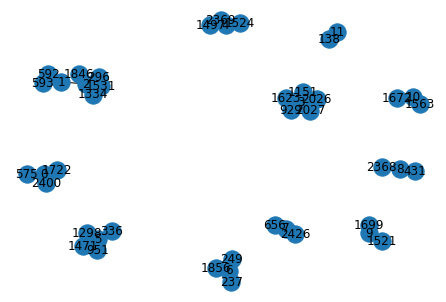

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import k_hop_subgraph

lcc = T.LargestConnectedComponents()(data)

n_samples = 35
# plot the graph
G = nx.Graph()
G.add_edges_from([(r1, r2) for r1, r2 in zip(lcc.edge_index.numpy()[0][:n_samples], lcc.edge_index.numpy()[1][:n_samples])])
nx.draw(G, cmap = plt.get_cmap('jet'), with_labels=True)
plt.show()